In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Define Directories
base_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/"
train_folds = [
    os.path.join(base_dir, "training_data/fold_0"),
    os.path.join(base_dir, "training_data/fold_1"),
    os.path.join(base_dir, "training_data/fold_2"),
]

all_dirs = [os.path.join(fold, "all") for fold in train_folds]
hem_dirs = [os.path.join(fold, "hem") for fold in train_folds]

# Get Image Paths and Labels
def get_image_paths(folder):
    return [os.path.join(folder, fname) for fname in os.listdir(folder)]

img_data = []
for folder in all_dirs + hem_dirs:
    img_data.extend(get_image_paths(folder))

data = pd.DataFrame({"img_data": img_data, "labels": [np.nan for _ in range(len(img_data))]})
data.loc[0:7271, "labels"] = 1  # ALL
data.loc[7272:10660, "labels"] = 0  # HEM
data["labels"] = data["labels"].astype("int64")

In [3]:
img_list = []
for path in data["img_data"]:
    image = cv.imread(path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh == 0] = [255, 255, 255]

    x, y, _ = np.where(result > 0)
    mnx, mxx = np.min(x), np.max(x)
    mny, mxy = np.min(y), np.max(y)
    crop_img = image[mnx:mxx, mny:mxy, :]
    crop_img_resized = cv.resize(crop_img, (224, 224))
    img_list.append(crop_img_resized)

X = np.array(img_list)
y = np.array(data["labels"])


--- Displaying Preprocessing Steps for a Single Image: /kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_28_5_3_all.bmp ---



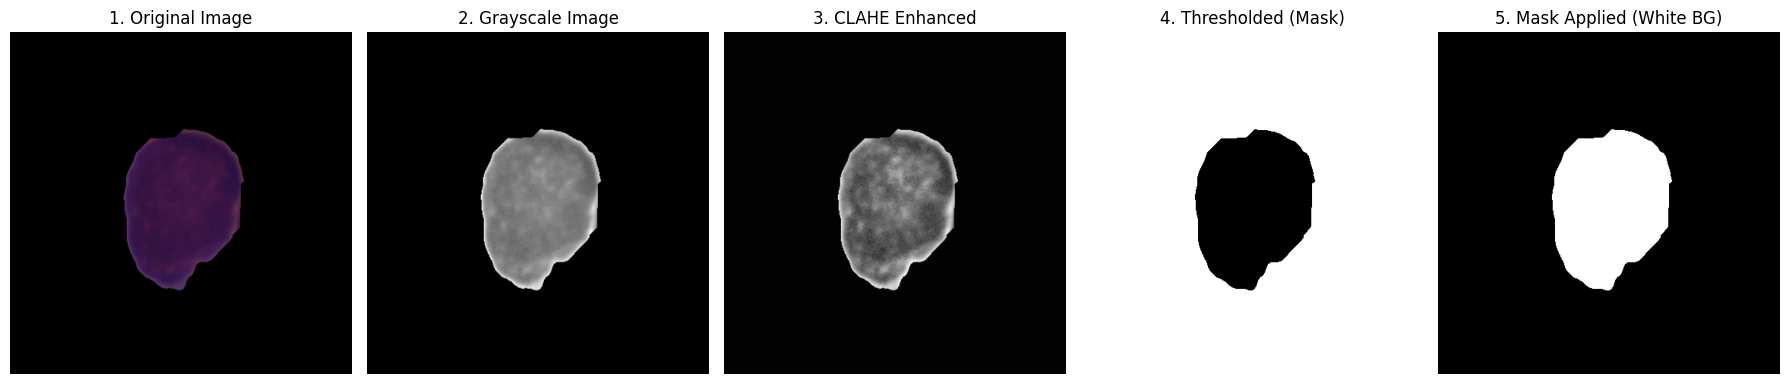

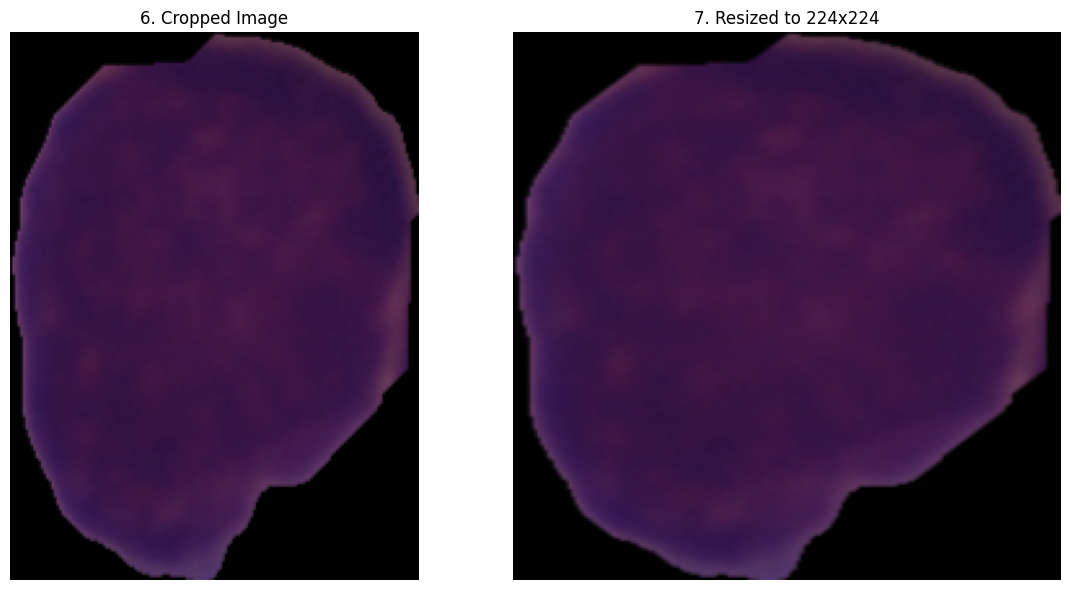

In [4]:

sample_image_path = data["img_data"][0] 

print(f"\n--- Displaying Preprocessing Steps for a Single Image: {sample_image_path} ---\n")

# Load the original image
image_display = cv.imread(sample_image_path)

# Display the original image
plt.figure(figsize=(18, 6)) 
plt.subplot(1, 5, 1)
plt.imshow(cv.cvtColor(image_display, cv.COLOR_BGR2RGB))
plt.title("1. Original Image")
plt.axis('off')

# Grayscale conversion
gray_display = cv.cvtColor(image_display, cv.COLOR_BGR2GRAY)
plt.subplot(1, 5, 2)
plt.imshow(gray_display, cmap='gray')
plt.title("2. Grayscale Image")
plt.axis('off')

# CLAHE enhancement
clahe_display = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_clahe_display = clahe_display.apply(gray_display)
plt.subplot(1, 5, 3)
plt.imshow(gray_clahe_display, cmap='gray')
plt.title("3. CLAHE Enhanced")
plt.axis('off')

# Thresholding
thresh_display = cv.threshold(gray_clahe_display, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
kernel_display = np.ones((3, 3), np.uint8)
thresh_display = cv.morphologyEx(thresh_display, cv.MORPH_OPEN, kernel_display, iterations=2)
plt.subplot(1, 5, 4)
plt.imshow(thresh_display, cmap='gray')
plt.title("4. Thresholded (Mask)")
plt.axis('off')

# Apply mask and remove background
result_display = cv.bitwise_and(image_display, image_display, mask=thresh_display)
result_display[thresh_display == 0] = [255, 255, 255] # Set background to white
plt.subplot(1, 5, 5)
plt.imshow(cv.cvtColor(result_display, cv.COLOR_BGR2RGB))
plt.title("5. Mask Applied (White BG)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Crop the significant region
x_display, y_display, _ = np.where(result_display > 0)
mnx_display, mxx_display = np.min(x_display), np.max(x_display)
mny_display, mxy_display = np.min(y_display), np.max(y_display)
crop_img_display = image_display[mnx_display:mxx_display, mny_display:mxy_display, :]

# Resize the cropped image
crop_img_resized_display = cv.resize(crop_img_display, (224, 224))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(crop_img_display, cv.COLOR_BGR2RGB))
plt.title("6. Cropped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(crop_img_resized_display, cv.COLOR_BGR2RGB))
plt.title("7. Resized to 224x224")
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False 

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, 
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 51s 175ms/step - accuracy: 0.7388 - loss: 0.6242 - val_accuracy: 0.8206 - val_loss: 0.4388
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.8083 - loss: 0.4454 - val_accuracy: 0.8277 - val_loss: 0.4160
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.8219 - loss: 0.4239 - val_accuracy: 0.8177 - val_loss: 0.4657
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - accuracy: 0.8227 - loss: 0.4314 - val_accuracy: 0.8441 - val_loss: 0.3937
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8297 - loss: 0.4120 - val_accuracy: 0.8400 - val_loss: 0.3887
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.8350 - loss: 0.3962 - val_accuracy: 0.8458 - val_loss: 0.3822
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.8361 - loss: 0.3906 - val_accuracy: 0.8224 - val_loss: 0.4117
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.8405 - loss: 0

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int) 

67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8475 - loss: 0.3467
Test Loss: 0.3423
Test Accuracy: 0.8631
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step


In [11]:
print("\nClassification Report:")
print(classification_report(y_test, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, binary_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75       678
           1       0.85      0.97      0.91      1455

    accuracy                           0.86      2133
   macro avg       0.88      0.80      0.83      2133
weighted avg       0.87      0.86      0.86      2133


Confusion Matrix:
[[ 435  243]
 [  49 1406]]


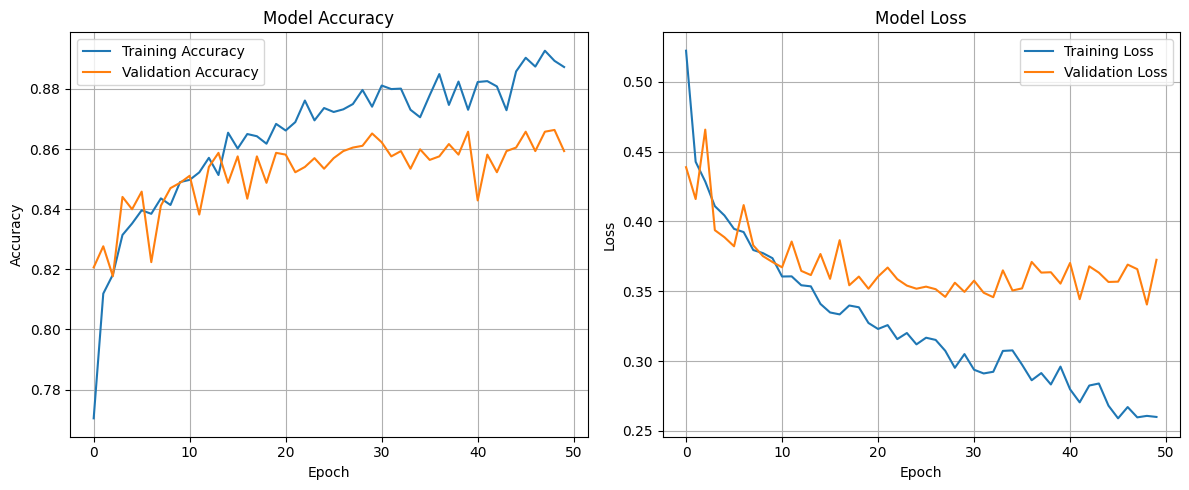

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

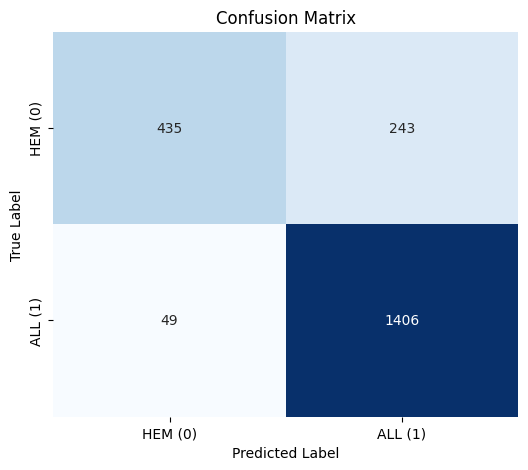


--- Confusion Matrix Details ---
True Negatives (Correctly predicted HEM): 435
False Positives (Predicted ALL, but was HEM): 243
False Negatives (Predicted HEM, but was ALL): 49
True Positives (Correctly predicted ALL): 1406


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, binary_predictions)
class_labels = ['HEM (0)', 'ALL (1)']

plt.figure(figsize=(6, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Confusion Matrix Details ---")
print(f"True Negatives (Correctly predicted HEM): {cm[0, 0]}")
print(f"False Positives (Predicted ALL, but was HEM): {cm[0, 1]}")
print(f"False Negatives (Predicted HEM, but was ALL): {cm[1, 0]}")
print(f"True Positives (Correctly predicted ALL): {cm[1, 1]}")